# Dashboard
* This notebook contains visualiations that could be incorporated into the final dashboard
* "Could your grandmother understand these visualizations?"

In [1]:
import ast
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import regex as re
import seaborn as sns

from dateutil.relativedelta import relativedelta
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from scipy.stats import chi2_contingency, mannwhitneyu

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from ipywidgets import widgets
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import json
import copy

# 0. Import and preprocess

In [5]:
# Import and join docket and court summary csv files
docketdf = pd.read_csv("docket-parsed.csv", index_col=0)
courtdf = pd.read_csv("court-parsed.csv", index_col=0)
df = docketdf.merge(courtdf, on='docket_no', how='left', suffixes=('', '_y'))
df.reset_index(inplace=True)
df.drop(columns=['docket_no'], inplace=True)
df.drop(df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [6]:
# convert string to datetime
df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = df["prelim_hearing_dt"].apply(
    lambda x: str(x).split(' ')[0] if pd.notnull(x) else x) # This is here because of a parsing issue
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])
df["prelim_hearing_time"] = pd.to_datetime(df["prelim_hearing_time"])

# age column
df['age'] = df['arrest_dt'] - df['dob']
df['age'] = df['age'].apply(lambda x: np.floor(x.days/365.2425))

# public defender column: 1 if public defender, 0 if private defender
# note that there is also an "attorney_type" column, with "Public", "Private", and "Court Appointed" options
df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert type of "offenses" from string representation of list to list
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
df['offense_type'] = df['offense_type'].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# column indicating whether zipcode is in Philadelphia
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

# outstanding bail column
df['bail_outstanding'] = df['bail_amount'] - df['bail_paid']

In [7]:
# Define bins for bail amount
def bin_bailSet(bailSet):
    if bailSet == 0 or pd.isnull(bailSet):
        return 'None'
    elif bailSet < 1000:
        return '<1k'
    elif bailSet < 5000:
        return '1k to 5k'
    elif bailSet < 10000:
        return '5k to 10k'
    elif bailSet < 25000:
        return '10k to 25k'
    elif bailSet < 50000:
        return '25k to 50k'
    elif bailSet < 100000:
        return '50k to 100k'
    elif bailSet < 500000:
        return '100k to 500k'
    else:
        return '>=500k'

# TODO: auto-generate bail_bin_labels to not have to manually update if updating fcn above
bail_bin_labels = ['None', '<1k', '1k to 5k', '5k to 10k', '10k to 25k', '25k to 50k', '50k to 100k', '100k to 500k', '>=500k']   
    
# column for bail amount bins
df['bail_set_bin'] = df['bail_amount'].apply(lambda x: bin_bailSet(x))

# column for bail outstanding bins
df['bail_outstanding_bin'] = df['bail_outstanding'].apply(lambda x: bin_bailSet(x))

In [8]:
# Define bins for age group
def bin_age(age):
    if age < 18:
        return 'minor'
    elif age < 26:
        return '18 to 25'
    elif age < 34:
        return '26 to 33'
    elif age < 42:
        return '34 to 41'
    elif age < 50:
        return '42 to 49'
    elif age < 58:
        return '50 to 57'
    elif age < 65:
        return '58 to 64'
    else:
        return 'senior'

# column for bail amount bins
df['age_group'] = df['age'].apply(lambda x: bin_age(x))

In [9]:
# remove arrests that occurred between 5/31 - 6/3 (BLM movement)
df = df[(df['arrest_dt'] < np.datetime64('2020-05-31')) | (df['arrest_dt'] > np.datetime64('2020-06-03'))]
df.reset_index(drop = True, inplace = True)

In [10]:
# full list of columns available to work with
sorted(df.columns.tolist())

['age',
 'age_group',
 'arrest_dt',
 'arresting_officer',
 'attorney',
 'attorney_type',
 'bail_amount',
 'bail_date',
 'bail_outstanding',
 'bail_outstanding_bin',
 'bail_paid',
 'bail_set_bin',
 'bail_set_by',
 'bail_type',
 'case_status',
 'dob',
 'offense_date',
 'offense_type',
 'offenses',
 'philly_zipcode',
 'prelim_hearing_dt',
 'prelim_hearing_time',
 'public_defender',
 'race',
 'sex',
 'statute',
 'zip',
 'zipcode_clean']

In [11]:
df.head()

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,...,sex,race,age,public_defender,zipcode_clean,philly_zipcode,bail_outstanding,bail_set_bin,bail_outstanding_bin,age_group
0,Defender Association of Philadelphia,Public,"[DUI: Gen Imp/Inc of Driving Safely - 1st Off,...",2019-12-31,"['75 § 3802', '75 § 3323']",[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,Male,White,25.0,0,19115,1,0.0,None,None,18 to 25
1,Joseph Kevin Kelly,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2019-12-31,['75 § 3802'],[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,Male,White,24.0,0,19134,1,0.0,None,None,18 to 25
2,Defender Association of Philadelphia,Public,[Retail Theft-Take Mdse],2019-12-31,['18 § 3929'],[theft and related offenses],"Bernard, Francis X.",0.0,0.0,2020-01-01,...,Male,Black,57.0,0,19131,1,0.0,None,None,50 to 57
3,Defender Association of Philadelphia,Public,"[Simple Assault, Recklessly Endangering Anothe...",2019-12-31,"['18 § 2701', '18 § 2705']","[assault, assault]","Bernard, Francis X.",30000.0,0.0,2020-01-01,...,Male,Black,32.0,0,19121,1,30000.0,25k to 50k,25k to 50k,26 to 33
4,Lee Mandell,Court Appointed,"[Robbery-Inflict Threat Imm Bod Inj, Conspirac...",2019-12-31,"['18 § 3701 §§ A1IV', '18 § 903 §§ C', '18 § 3...","[robbery, inchoate crimes, theft and related o...","Pittman, Joffie C. III",30000.0,0.0,2020-01-09,...,Male,Black,18.0,0,19135,1,30000.0,25k to 50k,25k to 50k,18 to 25


# 1. Aggregate bail information for the year 2020

In [9]:
# Total cases, distribution of bail set
totalCases = len(df.index)
print("Total number of cases analyzed (excluding 5/31 - 6/3): {0:,}".format(totalCases))

Total number of cases analyzed (excluding 5/31 - 6/3): 20,426


Monetary       8744
ROR            5627
Unsecured      5599
Nonmonetary     122
Nominal           4
Name: bail_type, dtype: int64


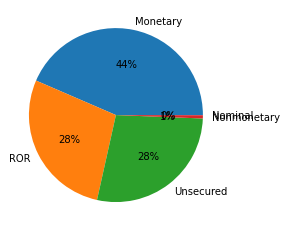

In [10]:
# Plot pie chart of bail type
# Note that this excludes cases where bail type was not recorded
df_bail = df['bail_type'].value_counts()
plt.pie(df_bail.values, labels=df_bail.keys().tolist(), autopct='%1.0f%%')

print(df_bail)

In [11]:
# Total amount of bail set
df_monetary = df[df['bail_type'] == "Monetary"]
totalBailSet = df_monetary['bail_amount'].sum()
totalBailPaid = df_monetary['bail_paid'].sum()
print("-> Monetary bail set in {0:.1f}% of cases".format(100*len(df_monetary)/df_bail.sum()))
print("\nTotal bail set: ${0:,}".format(totalBailSet))
print("Total bail paid: ${0:,} ({1:.1f}% of set)".format(totalBailPaid, 100*totalBailPaid/totalBailSet))

-> Monetary bail set in 43.5% of cases

Total bail set: $879,302,493.0
Total bail paid: $19,631,035.0 (2.2% of set)


In [42]:
# Bail set averages
print("Mean bail: \t${0:,.0f}".format(df_monetary['bail_amount'].mean()))
print("Median bail: \t${0:,.0f}".format(df_monetary['bail_amount'].median()))
print("Mode bail: \t${0:,.0f}".format(df_monetary['bail_amount'].mode()[0]))

Mean bail: 	$100,561
Median bail: 	$30,000
Mode bail: 	$25,000


In [47]:
# Bail paid averages
print("Mean bail paid: \t${0:,.0f}".format(df_monetary['bail_paid'].mean()))
print("Median bail paid: \t${0:,.0f}".format(df_monetary['bail_paid'].median()))
print("Mode bail paid: \t${0:,.0f}".format(df_monetary['bail_paid'].mode()[0]))
zeroPosted = df_monetary['bail_paid'].value_counts()[0.0]
print("In {0:.1f}% of cases with monetary bail, bail has not been posted".format(zeroPosted/))

Mean bail paid: 	$2,245
Median bail paid: 	$500
Mode bail paid: 	$0
In 4074.0% of cases with monetary bail, bail has not been posted


100k to 500k   23.3%
10k to 25k     22.2%
50k to 100k    17.7%
25k to 50k     16.7%
5k to 10k       9.5%
>=500k          4.8%
1k to 5k        3.3%
<1k             2.5%
None            0.0%
Name: bail_set_bin, dtype: float64
(For 8744 cases with monetary bail)


[Text(0.5, 0, 'Percentage'), Text(0, 0.5, 'Bail Set')]

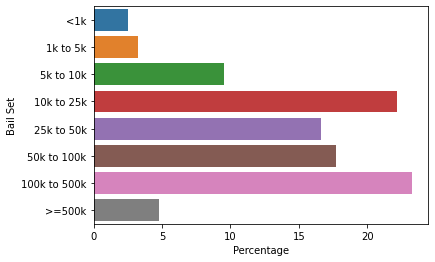

In [40]:
# Typical amounts of bail set, if monetary bail
series_monetary = df_monetary['bail_set_bin'].value_counts()
totalMonetary = sum(series_monetary)
series_monetary = series_monetary.apply(lambda x: 100*x/totalMonetary)
with pd.option_context('display.float_format', '{:,.1f}%'.format):
    print(series_monetary)
print("(For {0} cases with monetary bail)".format(totalMonetary))

# Plot counts of bail set bins
series_monetary = series_monetary.reindex(bail_bin_labels)
ax = sns.barplot(x=series_monetary.values, y=series_monetary.index, order=bail_bin_labels[1:])
ax.set(xlabel='Percentage', ylabel='Bail Set')

### Per Malik: Moving average (plot over time) of % of people getting bail, average amount of bail, # of cases getting bail

## Attorney type

In [21]:
ax.set(xlabel='common xlabel', ylabel='common ylabel')# Attorney types
df_defender = df['attorney_type'].value_counts()
totalAttorneys = sum(df_defender)
with pd.option_context('display.float_format', '{:,.1f}%'.format):
    print(df_defender.apply(lambda x: 100*x/totalAttorneys))
print("(For {0} cases with valid attorney type)".format(totalAttorneys))

Public            63.7%
Private           26.1%
Court Appointed   10.3%
Name: attorney_type, dtype: float64
(For 19259 cases with valid attorney type)


### Below is just the above reproduced in a sample interactive viz where one can use the slider to select a range of dates. Not sure how to incorporate the distribution of bail types yet.

*Also not sure whether `bail_date` or another date field should be used

In [13]:
# Get start/end dates for date range to be used in slider
start_date = df['bail_date'].min()
end_date = df['bail_date'].max()
dates = pd.date_range(start_date, end_date, freq='D')

In [14]:
# Turn dates into options on slider
options = [(date.strftime('%d %b %Y'), date) for date in dates]
index = (0, len(options)-1)

# Date range slider
select_date = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '550px'}
)

# Card for Case Count
cases = go.Indicator(
    mode = 'number',
    value = len(df),
    domain = {'row': 0, 'column': 0 }, 
    title = {'text': 'Total Cases'})

# Card for Monetary Bail Frequency
frequency = go.Indicator(
    mode = 'number',
    value = len(df[df['bail_type'] == 'Monetary']) / len(df) * 100.,
    number = {'suffix': '%'},
    domain = {'row': 0, 'column': 1 }, 
    title = {'text': 'Monetary Bail Frequency'})

# Card for Total Bail Amt
amount = go.Indicator(
    mode = 'number',
    value = df['bail_amount'].sum(),
    number = {'prefix': '$'},
    domain = {'row': 1, 'column': 0 }, 
    title = {'text': 'Total Bail Set'})

# Card for Total Bail Paid
paid = go.Indicator(
    mode = 'number',
    value = df['bail_paid'].sum(),
    number = {'prefix': '$'},
    domain = {'row': 1, 'column': 1 }, 
    title = {'text': 'Total Bail Paid'})

# Set up figure as 2x2 grid of the cards in the order specified
card_fig = go.FigureWidget()
card_fig.add_trace(cases)
card_fig.add_trace(frequency)
card_fig.add_trace(amount)
card_fig.add_trace(paid)
card_fig.update_layout(
    grid = {'rows': 2, 'columns': 2, 'pattern': "independent"})

# Function that updates each card based on the new date range selected on slider
def response(change):
    # New date range and filter df
    start, end = select_date.value[0], select_date.value[1]
    tmp = df[(df['bail_date'] >= start)&(df['bail_date'] <= end)]
    
    # Update values for each card
    card_fig.data[0].value = len(tmp)
    card_fig.data[1].value = len(tmp[tmp['bail_type'] == 'Monetary']) / len(tmp) * 100.
    card_fig.data[2].value = tmp['bail_amount'].sum()
    card_fig.data[3].value = tmp['bail_paid'].sum()

# Set up date range slider to update cards
select_date.observe(response, names='value')

widgets.VBox([select_date, card_fig])

# 2. Visualizations on magistrate information

## 2.1 Select magistrates to include in the analysis  
* Out of 612 magistrates in data, select magistrates to analyze

In [7]:
print('Total number of magistrates: ', len(df['bail_set_by'].value_counts()))

Total number of magistrates:  612


<b> Total number of cases handled by each magistrate </b>

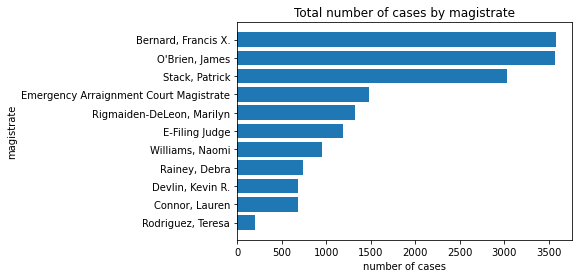

In [8]:
n_magistrates = 11
plt.barh(df['bail_set_by'].value_counts()[:n_magistrates].keys()[::-1], df['bail_set_by'].value_counts()[:n_magistrates].values[::-1])
plt.xlabel('number of cases')
plt.ylabel('magistrate')
plt.title('Total number of cases by magistrate')
plt.show()

In [9]:
df_magistrate = pd.crosstab(index = df['bail_set_by'], columns =df['bail_type'])
# note: total excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)
df_magistrate.sort_values(by = ['Total'], ascending = False, inplace = True)
print('Total number of magistrates (with valid bail type): {0}'.format(len(df_magistrate.index)))

Total number of magistrates (with valid bail type): 610


In [10]:
# Magistrates that were involved in more than caseFloor cases
caseFloor = 175
magistrates = df_magistrate[df_magistrate['Total'] > caseFloor].index
print("Number of magistrates with more than {0} cases: {1}".format(caseFloor, len(magistrates)))

Number of magistrates with more than 175 cases: 12


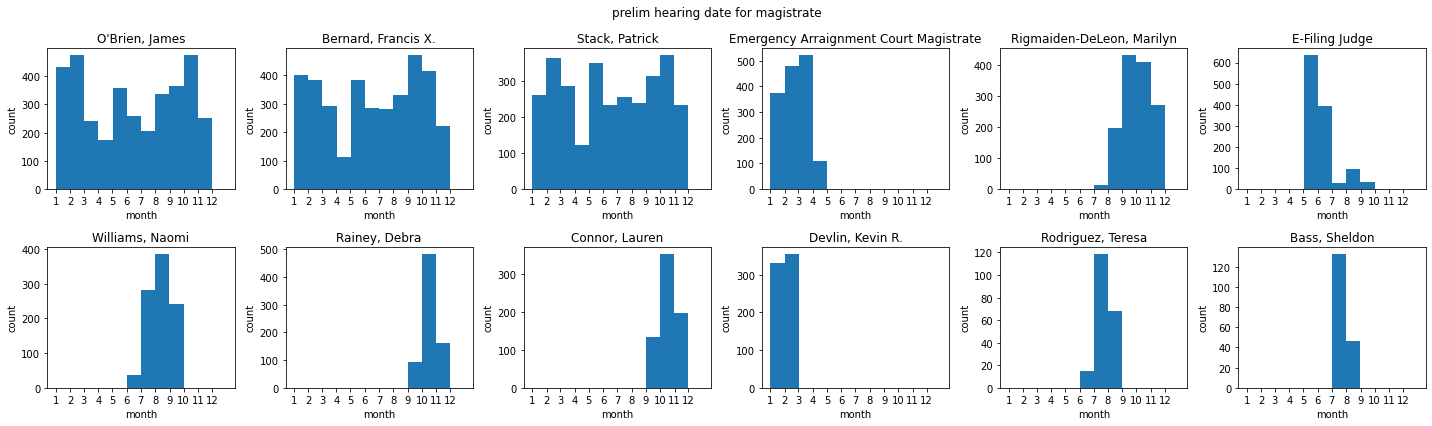

In [11]:
# get date ranges
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2020, 12, 31)
delta = relativedelta(months = 1)
date_range = []

while start_date <= end_date:
    date_range.append(start_date)
    start_date += delta

# plot
fig, ax = plt.subplots(nrows = 2, ncols = 6, figsize = (20, 6))
plt.rcParams['font.size'] = 10
fig.suptitle('prelim hearing date for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 6
    col = idx % 6
    ax[row][col].hist(df[df['bail_set_by'] == name].prelim_hearing_dt, bins = 12, range = (datetime.date(2020,1,1), datetime.date(2020, 12 ,31)))
    ax[row][col].set_title(name)

for sub in ax.flat:
    sub.set_xticks(date_range)
    sub.set_xticklabels([item.month for item in date_range])
    sub.set_xlabel('month')
    sub.set_ylabel('count')
plt.tight_layout()
plt.show()

* 'Emergency Arraignment Court Magistrate' and 'E-Filing Judge' are probably the same entity.
    * Are they filed under a different name starting October? Not sure why we don't see 'E-Filing Judge' after October
* There are a few people (Riamaiden-DeLeon, Williams, Rainey, Connor, Devlin, Rodriguez) that were involved in part of the year. 


In [12]:
# Correct 'Emergency Arraignment Court Magistrate' to 'E-Filing Judge'
df['bail_set_by'] = df['bail_set_by'].apply(lambda x: 'E-Filing Judge' if x == 'Emergency Arraignment Court Magistrate' else x)

In [98]:
# select magistrates 
magistrates = ['Bernard, Francis X.', 
               "O'Brien, James", 
               'Stack, Patrick', 
               'Rigmaiden-DeLeon, Marilyn',
               'E-Filing Judge', 
               'Williams, Naomi',
               'Rainey, Debra', 
               'Connor, Lauren', 
               'Devlin, Kevin R.']
print("Selected magistrates: ")
for name in magistrates:
    print(name)
    
# select core magistrates
core_magistrates = ['Bernard, Francis X.', 'Rigmaiden-DeLeon, Marilyn', "O'Brien, James", 'Stack, Patrick', 'E-Filing Judge']
print("\nSelected core magistrates: ")
for name in core_magistrates:
    print(name)

Selected magistrates: 
Bernard, Francis X.
O'Brien, James
Stack, Patrick
Rigmaiden-DeLeon, Marilyn
E-Filing Judge
Williams, Naomi
Rainey, Debra
Connor, Lauren
Devlin, Kevin R.

Selected core magistrates: 
Bernard, Francis X.
Rigmaiden-DeLeon, Marilyn
O'Brien, James
Stack, Patrick
E-Filing Judge


## 2.2 Are bail type and magistrate correlated?

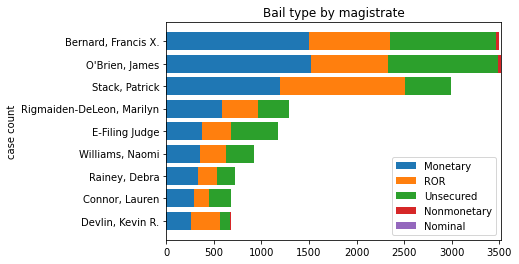

In [18]:
monetary = df_magistrate['Monetary'][magistrates].values[::-1]
ROR = df_magistrate['ROR'][magistrates].values[::-1]
Unsecured = df_magistrate['Unsecured'][magistrates].values[::-1]
Nonmonetary = df_magistrate['Nonmonetary'][magistrates].values[::-1]
Nominal = df_magistrate['Nominal'][magistrates].values[::-1]
ind = range(len(magistrates))

plt.barh(ind, monetary)
plt.barh(ind, ROR, left = monetary)
plt.barh(ind, Unsecured, left = monetary + ROR)
plt.barh(ind, Nonmonetary, left = monetary + ROR + Unsecured)
plt.barh(ind, Nominal, left = monetary + ROR + Unsecured + Nonmonetary)
plt.legend(labels = ['Monetary', 'ROR', 'Unsecured', 'Nonmonetary', 'Nominal'])
plt.ylabel('magistrate')
plt.yticks(ind, magistrates[::-1])
plt.ylabel('case count')
plt.title('Bail type by magistrate')
plt.show()

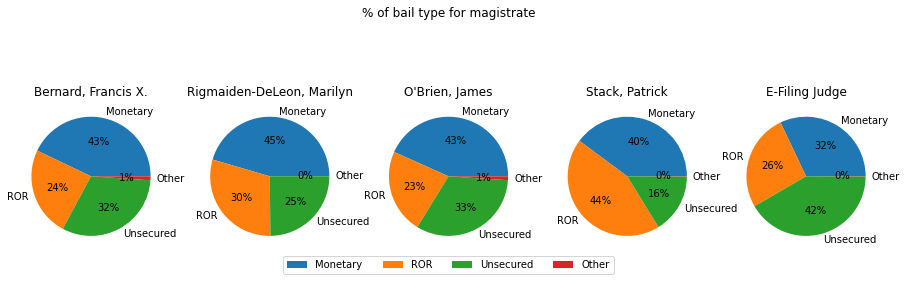

In [19]:
# Pie chart of core magistrates

# combine 'nominal' and 'nonmonetary' to 'other'
df_magistrate['Other'] = df_magistrate['Nominal'] + df_magistrate['Nonmonetary']

bail_types = ['Monetary','ROR', 'Unsecured', 'Other']
fig, ax = plt.subplots(ncols = 5, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(core_magistrates):
    ax[idx].pie(df_magistrate.loc[name, bail_types], labels = bail_types, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(-0.7, 0), ncol=4)

plt.show()

Q: Are bail type (monetary vs others) and magistrate related?  

In [20]:
# get column for non-monetary
df_magistrate['non_monetary'] = df_magistrate['Total'] - df_magistrate['Monetary']
df_chi = df_magistrate[['Monetary', 'non_monetary']]

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi.loc[core_magistrates])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  1.050701555979691e-12


* At significance level 0.01, chi-square test tells us that **bail type and magistrate are related.** 
* It's probably detecting the fact that bails set by E-Filing Judge is less likely to result in monetary bail, while bail set by Rigmaiden-DeLeon is more likely to result in monetary bail.

## 2.3 For monetary bail, does bail amount vary by magistrate? 

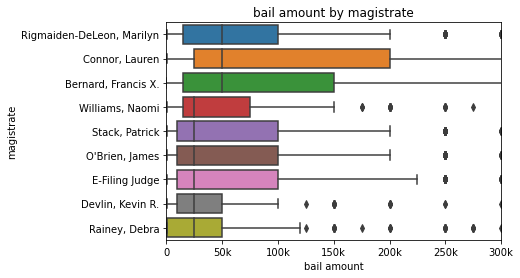

In [21]:
# plot bail amount (bar plot) by magistrate
df['magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['magistrate'] == 1)][['bail_set_by', 'bail_amount']]

# order by median amount
order = df_monetary.groupby(['bail_set_by']).bail_amount.median().sort_values(ascending = False).keys()

# plot
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], 
           order = order)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

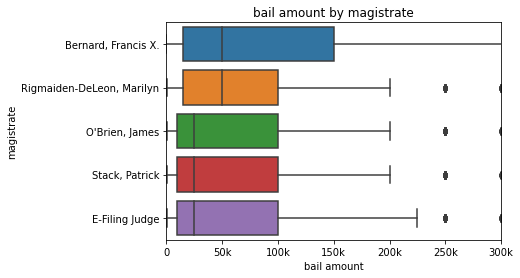

In [22]:
# plot bail amount (bar plot) for core magistrates
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['core_magistrate'] == 1)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

* It seems like Bernard and Rigmaiden-DeLeon sets higher bail amount than the others.
* To test this, either use t-test or Mann-Whitney U test  
* The following diagram shows that the distribution of bail amounts (for a fixed magistrate) is far from normal. Even log transform isn't enough. 
* We'll thus use Mann-Whitney U-test instead of t-test

Plot histogram of bail amount for a particular magistrate

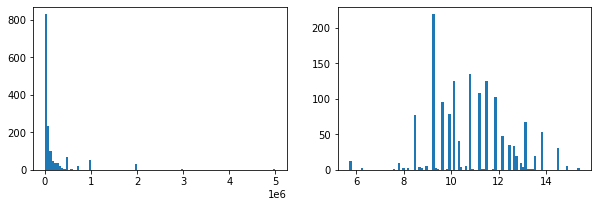

In [23]:
# ignore bail amount == 0
df_monetary = df[df['bail_type'] == 'Monetary'][['bail_set_by', 'bail_amount']]
df_monetary = df_monetary[df_monetary['bail_amount']!= 0]

# apply log transform
df_monetary['log_bail_amount'] = df_monetary['bail_amount'].apply(lambda x: np.log(x))

fig, ax = plt.subplots(ncols = 2, figsize = (10, 3))
ax[0].hist(df_monetary[df_monetary["bail_set_by"] == 'Bernard, Francis X.'].bail_amount, bins =100)
ax[1].hist(df_monetary[df_monetary["bail_set_by"] == 'Bernard, Francis X.'].log_bail_amount, bins =100)
plt.show()

* log transform doesn't help in getting the distribution to look normal.
* Instead of doing a t-test, we'll use a non-parametric test: Mann-Whitney U-test  
* Perform Mann-Whitney U-test on every pair of magistrates

In [24]:
# create order of magistrates
# note: the index was manually decided to make the correlation matrix look nice.

magistrate_order = ['Bernard, Francis X.',
                    'Rigmaiden-DeLeon, Marilyn',
                    'Stack, Patrick',
                    "O'Brien, James",
                    'E-Filing Judge',
                    'Williams, Naomi',
                    'Rainey, Debra',
                    'Connor, Lauren',
                    'Devlin, Kevin R.']

magistrate_index = {}
for idx, person in enumerate(magistrate_order):
    magistrate_index[person] = idx

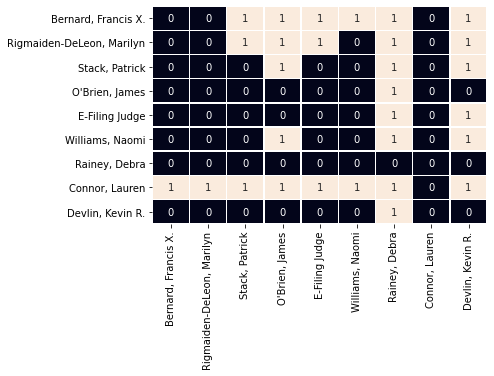

In [25]:
# matrix of differences
df_monetary = df[(df['bail_type'] == 'Monetary')][['bail_set_by', 'bail_amount']]
n_magistrates = len(magistrate_order)
diff_matrix = np.zeros((n_magistrates, n_magistrates))

for magistrate1 in magistrate_order:
    for magistrate2 in magistrate_order:
        if magistrate1 != magistrate2:
            # select data for two magistrates
            data1 = df_monetary[df_monetary['bail_set_by'] == magistrate1].bail_amount
            data2 = df_monetary[df_monetary['bail_set_by'] == magistrate2].bail_amount

            # Mann-Whitney U test 
            statistic, pvalue = mannwhitneyu(data1, data2, alternative = 'greater')
            
            # save p-values
            if pvalue < 0.01:
                idx1 = magistrate_index[magistrate1]
                idx2 = magistrate_index[magistrate2]

                diff_matrix[idx1, idx2] = 1
  
        
# plot
g = sns.heatmap(diff_matrix, linewidths=.5, annot = True, cbar = False)
g.set_xticklabels(magistrate_order, rotation = 90)
g.set_yticklabels(magistrate_order, rotation = 0)
plt.show()

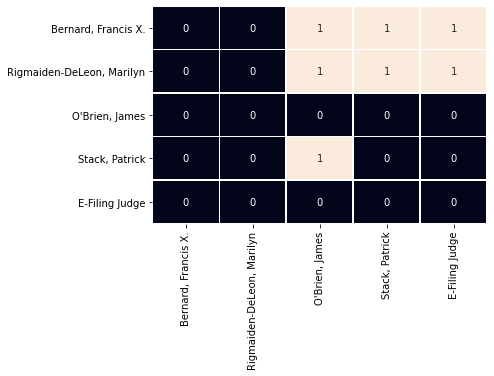

In [26]:
# matrix of differences (Just for core magistrates)
magistrate_index = {}
for idx, person in enumerate(core_magistrates):
    magistrate_index[person] = idx


df_monetary = df[(df['bail_type'] == 'Monetary')][['bail_set_by', 'bail_amount']]
n_magistrates = len(core_magistrates)
diff_matrix = np.zeros((n_magistrates, n_magistrates))

for magistrate1 in core_magistrates:
    for magistrate2 in core_magistrates:
        if magistrate1 != magistrate2:
            # select data for two magistrates
            data1 = df_monetary[df_monetary['bail_set_by'] == magistrate1].bail_amount
            data2 = df_monetary[df_monetary['bail_set_by'] == magistrate2].bail_amount

            # Mann-Whitney U test 
            statistic, pvalue = mannwhitneyu(data1, data2, alternative = 'greater')
            
            # save p-values
            if pvalue < 0.01:
                idx1 = magistrate_index[magistrate1]
                idx2 = magistrate_index[magistrate2]

                diff_matrix[idx1, idx2] = 1
  
        
# plot
g = sns.heatmap(diff_matrix, linewidths=.5, annot = True, cbar = False)
g.set_xticklabels(core_magistrates, rotation = 90)
g.set_yticklabels(core_magistrates, rotation = 0)
plt.show()

* Interpretation
    * If entry at particular row and column is white: Bail set by row-magistrate is likely to be higher than bail set by column-magistrate
    * If X: bail set by row magistrate, Y: bail set by column-magistrate, P(X>Y) > 0.5
* first row: Bail set by Bernard is likely to be higher than bail set by O'Brien, Stack, and E-Filing Judge
* second row: Bail set by Rigmaiden-DeLeon is likely to be higher than bail set by O'Brien, Stack, E-filing Judge
* third row: Bail set by Stack is likely to be higher than O'Brien
    * This was a bit confusing. See the following histogram

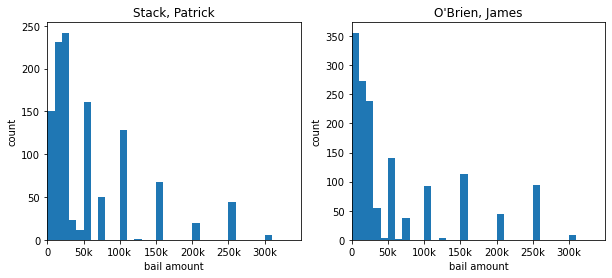

In [27]:
# why is there a difference between Stack and O'Brien?
bins = range(0, 350000, 10000)
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
ax[0].hist(df_monetary[df_monetary['bail_set_by'] == "Stack, Patrick"].bail_amount, bins = bins)
ax[0].set_title("Stack, Patrick")
ax[1].hist(df_monetary[df_monetary['bail_set_by'] == "O'Brien, James"].bail_amount, bins = bins)
ax[1].set_title("O'Brien, James")

for sub in ax.flat:
    sub.set_xlim((0, 350000))
    sub.set_xticks(range(0,350000,50000))
    sub.set_xticklabels(['0','50k','100k','150k','200k','250k','300k'])
    sub.set_xlabel('bail amount')
    sub.set_ylabel('count')
plt.show()

## 2.4 Are preliminary hearing date and time related to magistrates?

This may be relevant, as offense severity may depend on hearing time 

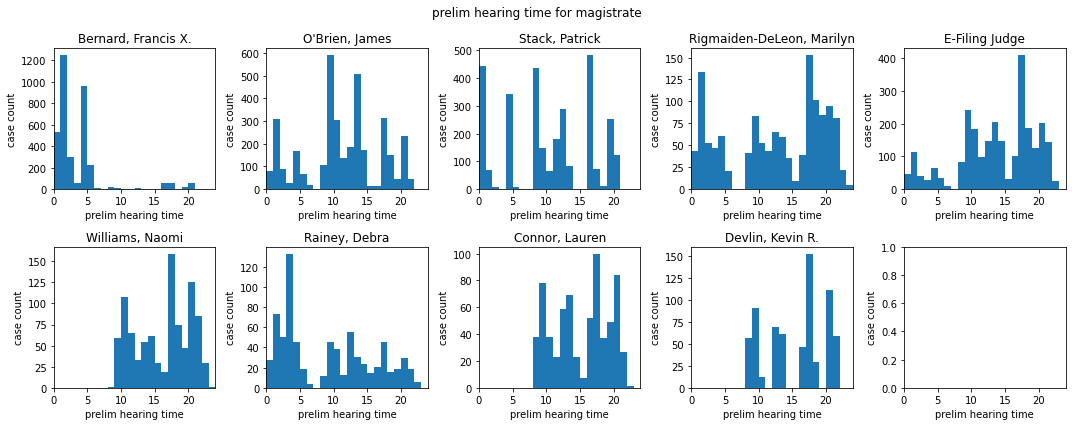

In [28]:
df['prelim_hearing_hour'] = df['prelim_hearing_time'].apply(lambda x: x.hour)
# prelim hearing time (hour) of each magistrate

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 6))
plt.rcParams['font.size'] = 10
fig.suptitle('prelim hearing time for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 5
    col = idx % 5 
    ax[row][col].hist(df[df['bail_set_by'] == name].prelim_hearing_hour, bins=24, range=(0,24))
    ax[row][col].set_title(name)

for sub in ax.flat:
    sub.set_xlim(0,24)
    sub.set_xlabel('prelim hearing time')
    sub.set_ylabel('case count')
plt.tight_layout()
plt.show()

## 2.5 Are specific magistrates more likely to handle specific types of offenses?

* Analysis 1: Using topic modeling (via NMF) to extract offense type
* Analysis 2: Using offense types parsed from statute numbers


#### 2.5 Analysis 1: Using topic modeling

<b> Remove offenses with super long length </b>

In [29]:
# remove offenses with super long length
df['max_offense_length'] = df['offenses'].apply(lambda x: max([len(item) for item in x]))

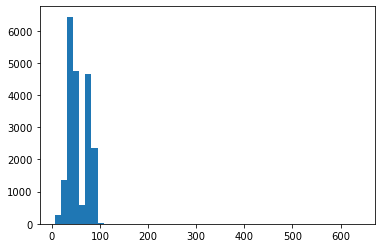

In [30]:
plt.hist(df['max_offense_length'], bins = 50)
plt.show()

In [31]:
df_long = df[df['max_offense_length'] > 200]

In [32]:
df_long['offenses']

9529     [Rape Forcible Compulsion, Unlawful Contact Wi...
10018    [Photograph/Film/Depict on Computer Sex Act - ...
Name: offenses, dtype: object

Error with parsing offenses

In [33]:
df.at[9529, 'offenses']

['Rape Forcible Compulsion',
 'Unlawful Contact With Minor - Sexual Offenses',
 'Unlawful Restraint/ Serious Bodily Injury',
 'Sexual Assault',
 'Corruption Of Minors - Defendant Age 18 or Above',
 'Endangering Welfare of Children - Parent/Guardian/Other Commits Offense',
 'Indecent Assault Forcible Compulsion',
 'Statutory Sexual Assault: 11 Years Older Rape of Child IDSI Forcible Compulsion',
 'Rape of Child IDSI Forcible Compulsion Incarceration/Diversionary Period Disposition Date Offense Disposition Sentence Date 06/16/2020 Proceed to Court Proceed to Court Proceed to Court Proceed to Court Proceed to Court F1 F1 F2 F2 F3',
 'IDSI Forcible Compulsion']

In [34]:
# remove offenses with long length
df['cleaned_offenses'] = df['offenses'].apply(lambda x: [item for item in x if len(item) < 200])

# manually adjust for item 10678
df.at[10018, 'cleaned_offenses'] = ['Photograph/Film/Depict on Computer Sex Act - Knowingly or Permitting Child',
                                    'Child Pornography']

<b> topic modeling via NMF </b>

In [35]:
def cleanText(text):
    
    # remove punctuations
    text = re.sub('\,','', text)
    text = re.sub('\.','', text)
    text = re.sub('\:','', text)
    text = re.sub('\-', ' ',text)
    
    return text

In [36]:
# prepare text (offenses)
df['corpus'] = df['cleaned_offenses'].apply(lambda x: ' '.join(x))
df['corpus'] = df['corpus'].apply(cleanText)
corpus = df['corpus'].tolist()

# remove stop words
stopwords = ['for','a','of','the','and','to','in', 'or']

# corpus format: list of list
# lowercase
corpus = [[word for word in text.lower().split() if word not in stopwords] for text in corpus]

# create dictionary of worrds
dictionary = Dictionary(corpus)

# prepare corpus
total_corpus = [dictionary.doc2bow(text) for text in corpus]

In [ ]:
# compute coherence scores for NMF models of various topic numbers
topic_numbers = list(range(2,30))
scores = {}

for k in topic_numbers:
    # train NMF model
    nmf = Nmf(total_corpus, id2word = dictionary, kappa = 0.1, passes = 20, num_topics = k, normalize = True)
    
    # compute coherence on cv
    cm = CoherenceModel(model=nmf, texts=corpus, coherence='u_mass')
    coherence = cm.get_coherence() 
    scores[k] = coherence

In [ ]:
plt.plot(topic_numbers, [scores[item] for item in topic_numbers])
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('coherence scores')
plt.show()

The U-mass coherence score plateaus around 8. So appropriate topic number is around 10-20

In [ ]:
# train NMF model
n_topics = 11
nmf = Nmf(total_corpus, id2word = dictionary, kappa = 0.1, passes =20, num_topics = n_topics, normalize = True)

In [ ]:
# Visualize topic representations 
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 14))

for i in range(n_topics):
    row = i // 3
    col = i % 3
    
    topic_rep = nmf.show_topic(i)
    words = [item[0] for item in topic_rep][::-1]
    prob = [item[1] for item in topic_rep][::-1]
    
    ax[row][col].barh(words, prob)
    ax[row][col].tick_params(axis="y", labelsize=14)
    ax[row][col].set_xlabel('probability')
    ax[row][col].set_title('Representations of topic '+ str(i))
    
fig.subplots_adjust(wspace=0.4, hspace = 0.3)
plt.show()

In [37]:
# save NMF model
#nmf.save('offenses_nmf')

# to load
nmf = Nmf.load('offenses_nmf')

In [38]:
# for each offense, assign topic number 
topic_numbers = []

for case in total_corpus:
    topics = nmf[case]
    topic_num = [item[0] for item in topics]
    topic_prob = [item[1] for item in topics]
    topic_numbers.append(topic_num[topic_prob.index(max(topic_prob))])
    
# create column of offense type
df['topic_numbers'] = topic_numbers

<b> Q: Are there correlations between offense type and magistrate? </b>

In [39]:
df_magistrate_offense = pd.crosstab(index = df['bail_set_by'], columns =df['topic_numbers'])
df_magistrate_offense['Total'] = df_magistrate_offense.sum(axis = 1)

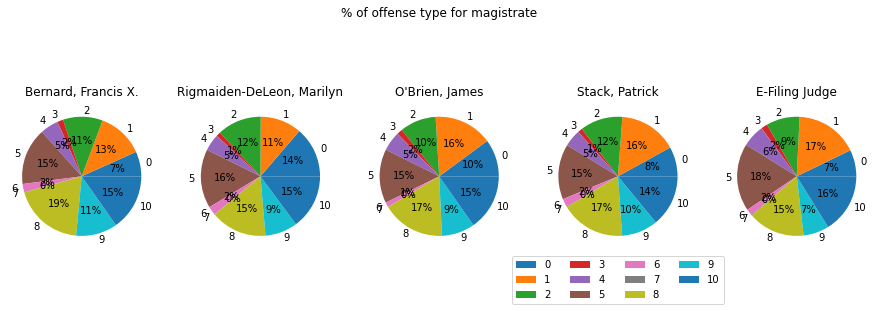

In [42]:
# visualize
n_topics = 11
topic_nums = list(range(n_topics))

fig, ax = plt.subplots(ncols = 5, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of offense type for magistrate')
for idx, name in enumerate(core_magistrates):

    ax[idx].pie(df_magistrate_offense.loc[name, topic_nums], labels = topic_nums, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.show()

From what we see above, each magistrate seems to handle similar proportions of offense types

In [43]:
# test
df_chi = df_magistrate_offense.drop(columns = ['Total'])

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi.loc[core_magistrates])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  1.1638107625891838e-25


From the above, it's kind of hard to tell why we get a significant result. we may need more specific tests

<b>To do</b>: Do chi-square test for each topic number as following: topic i vs non-topic i

In [387]:
def chisquare_by_topic(df_magistrate_offense, topic_num, magistrates):
    df_chi = df_magistrate_offense.loc[magistrates]
    df_chi['not'] = df_chi['Total'] - df_chi[topic_num]
    # chi-squared test"
    chi2, p, dof, ex = chi2_contingency(df_chi[[topic_num, 'not']])
    return p

In [45]:
# chi-square test for topics 0-5
for i in range(n_topics):
    p = chisquare_by_topic(df_magistrate_offense, i, core_magistrates)
    print('p-value of chi-square test for topic %d : %.4f' %(i,p))
    

p-value of chi-square test for topic 0 : 0.0000
p-value of chi-square test for topic 1 : 0.0000
p-value of chi-square test for topic 2 : 0.0067
p-value of chi-square test for topic 3 : 0.5098
p-value of chi-square test for topic 4 : 0.1001
p-value of chi-square test for topic 5 : 0.0010
p-value of chi-square test for topic 6 : 0.0160
p-value of chi-square test for topic 7 : 0.6272
p-value of chi-square test for topic 8 : 0.0007
p-value of chi-square test for topic 9 : 0.0000
p-value of chi-square test for topic 10 : 0.2581


* The above shows that some magistrates are more likely to handle cases involving particular offenses.
* When we analyze magistrate's effect on bail type and bail amount, we should do a matched analysis

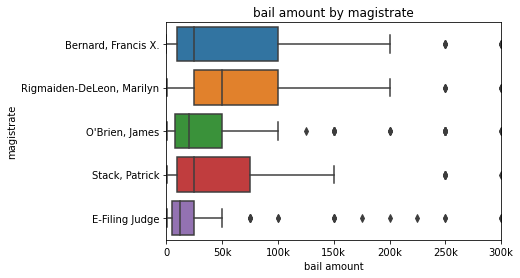

In [46]:
# for offense of type 8 (drug possession and delivery), do the bail amount differ by magistrate?
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['core_magistrate'] == 1) & (df['topic_numbers'] == 8)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

It does look like given the same offense type (drug possession and delivery) Bernard and Rigmaiden-DeLeon tend to set higher bails than the others

#### 2.5 Analysis 2: Using offense types parsed from statute info

In [380]:
offense_types = []
for i in range(df.shape[0]):
    case_offense = df.at[i,'offense_type']
    for item in case_offense:
        if item not in offense_types:
            offense_types.append(item)
            
n_offense_type = len(offense_types)
print('number of offense types: ', n_offense_type)

number of offense types:  38


In [381]:
# add offense type as separate columns
df[offense_types] = 0

# entry 1 if the particular offense type occured in the case
for i in range(df.shape[0]):
    case_offense = df.at[i,'offense_type']
    for item in case_offense: 
        for category in offense_types:
            if item == category:
                df.at[i, category] = 1

In [383]:
# frequency of offense types
df[offense_types].sum(axis = 0).sort_values(ascending = False)[:10]

assault                                                     7405
inchoate crimes                                             7331
drug and substance                                          5735
theft and related offenses                                  3808
firearms and other dangerous articles                       3135
arson, criminal mischief, and other property destruction    1726
burglary and other criminal intrusion                       1721
driving after imbibing alcohol or utilizing drugs           1696
robbery                                                     1107
domestic relations and abuse                                 864
dtype: int64

In [384]:
# combine offense types with frequency < 50 into one column 'offense type: other'

offense_type_others = df[offense_types].sum(axis = 0).sort_values(ascending = False)[-9:].keys()
df['offense_type_others'] = df[offense_type_others].sum(axis=1)
df.drop(columns = offense_type_others, inplace = True)
offense_types = [item for item in offense_types if item not in offense_type_others]
offense_types.append('offense_type_others')

In [385]:
# correlation between offense type and magistrate information
df_offense = df.groupby('bail_set_by').sum()[offense_types]
df_offense = df_offense.loc[core_magistrates]
df_offense['Total'] = df_offense.sum(axis = 1)

In [388]:
print('Topics with significant p-values')
for topic in offense_types:
    p = chisquare_by_topic(df_offense, topic, core_magistrates)
    if p < 0.05:
        print('p-value for topic %s : %.4f' %(topic, p))

Topics with significant p-values
p-value for topic driving after imbibing alcohol or utilizing drugs : 0.0000
p-value for topic general traffic offense : 0.0017
p-value for topic assault : 0.0126
p-value for topic drug and substance : 0.0000
p-value for topic firearms and other dangerous articles : 0.0000
p-value for topic sexual offenses : 0.0069
p-value for topic kidnapping : 0.0145
p-value for topic burglary and other criminal intrusion : 0.0000
p-value for topic forgery and fraudulent practices : 0.0000
p-value for topic domestic relations and abuse : 0.0002
p-value for topic vehicles: lighting equipment : 0.0002
p-value for topic falsification and intimidation : 0.0005
p-value for topic criminal homicide : 0.0008
p-value for topic other offenses : 0.0014
p-value for topic minors : 0.0071
p-value for topic offense_type_others : 0.0453


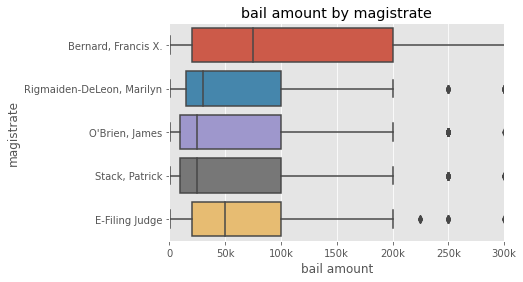

In [389]:
# for offense of type assault, do the bail amount differ by magistrate?
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['core_magistrate'] == 1) & (df['assault'] == 1)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df_monetary["bail_amount"], order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

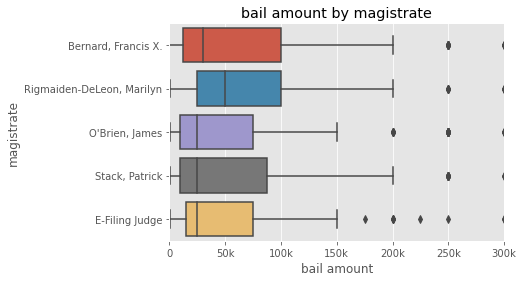

In [390]:
# for offense of type "drug possession and delivery", do the bail amount differ by magistrate?
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['core_magistrate'] == 1) & (df['drug and substance'] == 1)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x = df_monetary["bail_amount"], order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

### 2.6 Do bail type and bail amount depend on the magistrate (controlling for offenses)? 

#### Matched study   
* The above analysis shows that offense types are not equally represented across magistrates. (That is, some magistrates are more likely to handle cases involving specific offenses)  
* We want to examine whether bail type and bail amount depends on the magistrate while controling for the difference in offense type. 
* Conduct a matched study, where we pair the cases handled by each magistrate based on offenses.
* Use the statute numbers to perform the matching.

In [340]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
plt.style.use('ggplot')

In [ ]:
# fix 'statute' column format
df['statute'] = df['statute'].apply(lambda x: ast.literal_eval(x))

In [342]:
# Extract cases involving core magistrates
df_core = df[df['core_magistrate'] == 1]
df_core.reset_index(drop = True, inplace = True)

In [343]:
# number of different offenses (statutes) represented
all_statutes = []
for i in range(df_core.shape[0]):
    statutes = df_core.at[i,'statute']
    for item in statutes:
        if item not in all_statutes:
            all_statutes.append(item)
            
n_statutes = len(all_statutes)
print('number of statutes: ', n_statutes)

number of statutes:  470


In [344]:
# Create new columns, one for each statute
df_core[all_statutes] = 0

# update columns for each statute
for i in range(df_core.shape[0]):
    statutes = df_core.at[i,'statute']
    for item in statutes: 
        for category in all_statutes:
            if item == category:
                df_core.at[i, category] += 1

In [345]:
# compute distance among cases based on statute
dis = pdist(np.array(df_core[all_statutes]), 'cosine')
distance = squareform(dis)

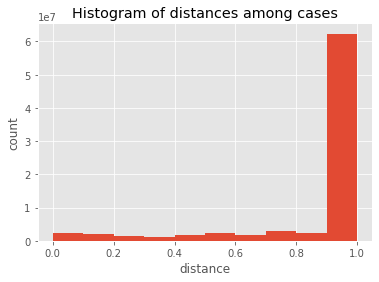

In [349]:
# plot histogram of pairwise distances amogn cases
plt.hist(dis)
plt.xlabel('distance')
plt.ylabel('count')
plt.title('Histogram of distances among cases')
plt.show()

Examples of similar cases and their distances

In [364]:
# Example cases whose distance is around "d"
args = np.where(np.isclose(distance, 0.1))

case1 = args[0][0]
case2 = args[1][0]

print('distance between case %d and %d: %.3f' %(case1, case2, distance[case1, case2]))
print('\noffenses for case %d' %case1)
for item in df_core.at[case1,'offenses']:
    print(item)
print('\noffenses for case %d' %case2)
for item in df_core.at[case2,'offenses']:
    print(item)

distance between case 87 and 90: 0.100

offenses for case 87
Robbery-Inflict Serious Bodily Injury
Robbery Of Motor Vehicle
Firearms Not To Be Carried W/O License
Theft By Unlaw Taking-Movable Prop
Receiving Stolen Property
Carry Firearms Public In Phila
Poss Instrument Of Crime W/Int
Terroristic Threats W/ Int To Terrorize Another
Simple Assault
Recklessly Endangering Another Person

offenses for case 90
Robbery-Inflict Serious Bodily Injury
Possession Of Firearm Prohibited
Firearms Not To Be Carried W/O License
Carry Firearms Public In Phila
Theft By Unlaw Taking-Movable Prop
Receiving Stolen Property
Poss Instrument Of Crime W/Int
Terroristic Threats W/ Int To Terrorize Another
Simple Assault
Recklessly Endangering Another Person


In [365]:
# create dataframe for matched dataset
columns = df_core.columns
df_matched = pd.DataFrame(columns = columns)

In [367]:
n_cases = df_core.shape[0]

for i in range(n_cases):
    
    # check that index "i" is present in df_core
    if i in df_core.index:
    
        # find all cases with distance <= 0.01 
        possible_idx = np.argwhere(distance[i,:] <= 0.01).flatten().tolist()
        possible_idx = [item for item in possible_idx if item in df_core.index]

        # check if core magistrates all appear
        df_possible = df_core.loc[possible_idx]
        if len(df_possible.bail_set_by.value_counts()) == len(core_magistrates):
            
            # add case to df_matched
            df_matched = pd.concat([df_matched, df_core.loc[[i]]])
            # record magistrate
            magistrate = df_core.at[i,'bail_set_by']
            # remove case from df_core
            df_core.drop(i, inplace = True)

            # add the closest cases for each magistrate
            for name in core_magistrates:
                if name != magistrate: 
                    idx = df_possible[df_possible['bail_set_by'] == name].index
                    j = np.argmin(distance[i, idx])
                    df_matched = pd.concat([df_matched, df_core.loc[[idx[j]]]])
                    df_core.drop(idx[j], inplace = True)   
                    
# reset index                   
df_matched.reset_index(inplace = True)

In [371]:
print('number of matched cases: ', df_matched.shape[0])

number of matched cases:  2490


In [372]:
# To check the matched cases, the result of the following should give cases of similar offense types 
# assigned to 5 different magistrates

# enter any multiple of 5 as i
i = 2400 
df_matched.loc[i:i+4]

,index,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,...,18 § 7306,18 § 2905,75 § 6308,18 § 3122.1 §§ A2 18 § 3126 §§ A2,18 § 910,18 § 5124,18 § 6106.1 18 § 2705,75 § 3322,18 § 2707.2,core_magistrate
2400,4773,Lauren A. Wimmer,Court Appointed,"[Theft By Unlaw Taking-Movable Prop, Receiving...",05/22/2020,"[18 § 3921, 18 § 3925, 18 § 3928]","[theft and related offenses, theft and related...","Stack, Patrick",0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2401,6583,Defender Association of Philadelphia,Public,"[Theft By Unlaw Taking-Movable Prop, Receiving...",07/07/2020,"[18 § 3921, 18 § 3925, 18 § 3928]","[theft and related offenses, theft and related...","Bernard, Francis X.",25000.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2402,12491,Defender Association of Philadelphia,Public,"[Theft By Unlaw Taking-Movable Prop, Receiving...",11/18/2020,"[18 § 3921, 18 § 3925, 18 § 3928]","[theft and related offenses, theft and related...","Rigmaiden-DeLeon, Marilyn",0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2403,6548,Defender Association of Philadelphia,Public,"[Theft By Unlaw Taking-Movable Prop, Receiving...",07/04/2020,"[18 § 3921, 18 § 3925, 18 § 3928]","[theft and related offenses, theft and related...","O'Brien, James",0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2404,6530,Defender Association of Philadelphia,Public,"[Theft By Unlaw Taking-Movable Prop, Receiving...",06/18/2020,"[18 § 3921, 18 § 3925, 18 § 3928]","[theft and related offenses, theft and related...",E-Filing Judge,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [376]:
# number of cases per magistrate
df_matched.groupby('bail_set_by').index.count()

bail_set_by
Bernard, Francis X.          498
E-Filing Judge               498
O'Brien, James               498
Rigmaiden-DeLeon, Marilyn    498
Stack, Patrick               498
Name: index, dtype: int64

In [373]:
# save
# df_matched.to_csv('matched_data.csv')

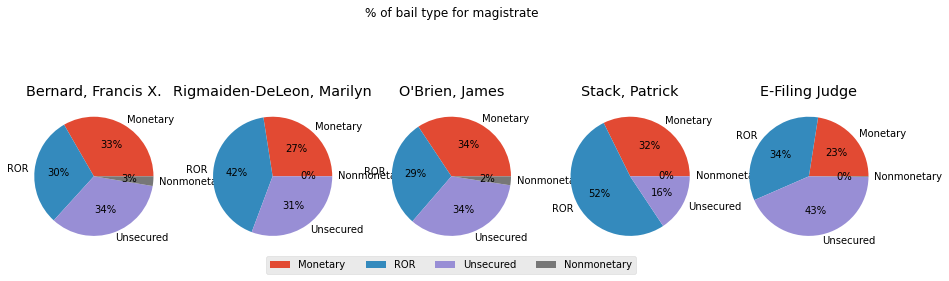

In [377]:
# bail type for matched cases

# combine 'nominal' and 'nonmonetary' to 'other'
df_bailtype = pd.crosstab(index = df_matched['bail_set_by'], columns =df_matched['bail_type'])

bail_types = ['Monetary','ROR', 'Unsecured', 'Nonmonetary']
fig, ax = plt.subplots(ncols = 5, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(core_magistrates):
    ax[idx].pie(df_bailtype.loc[name, bail_types], labels = bail_types, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(-0.7, 0), ncol=4)

plt.show()

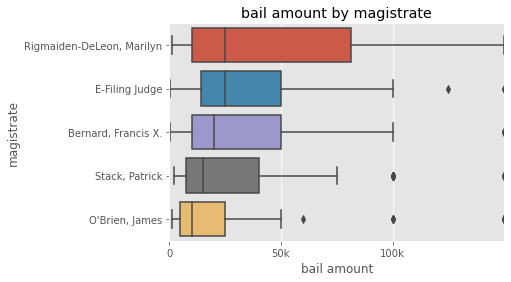

In [378]:
# bail amount for matched cases
magistrates_list = ['Rigmaiden-DeLeon, Marilyn', 'E-Filing Judge', 'Bernard, Francis X.', 'Stack, Patrick', "O'Brien, James"]
df_plot = df_matched[(df_matched['bail_type'] == 'Monetary')][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y = df_plot["bail_set_by"], x = df_plot["bail_amount"], order = magistrates_list)
plt.xlim(0, 150000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 150000, 50000), labels = ['0','50k','100k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

Are these differences statistically significant?

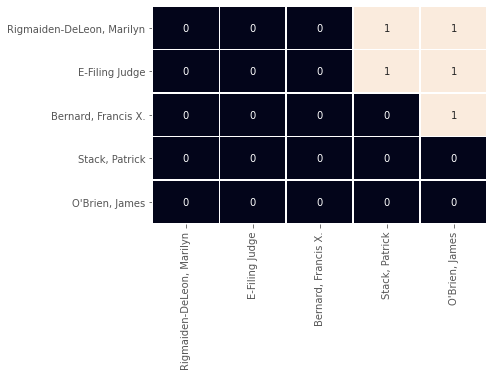

In [379]:
# matrix of differences (Just for core magistrates)
magistrate_index = {}
for idx, person in enumerate(magistrates_list):
    magistrate_index[person] = idx


df_monetary = df_matched[(df_matched['bail_type'] == 'Monetary')][['bail_set_by', 'bail_amount']]
n_magistrates = len(magistrates_list)
diff_matrix = np.zeros((n_magistrates, n_magistrates))

for magistrate1 in core_magistrates:
    for magistrate2 in core_magistrates:
        if magistrate1 != magistrate2:
            # select data for two magistrates
            data1 = df_monetary[df_monetary['bail_set_by'] == magistrate1].bail_amount
            data2 = df_monetary[df_monetary['bail_set_by'] == magistrate2].bail_amount

            # Mann-Whitney U test 
            statistic, pvalue = mannwhitneyu(data1, data2, alternative = 'greater')
            
            # save p-values
            if pvalue < 0.01:
                idx1 = magistrate_index[magistrate1]
                idx2 = magistrate_index[magistrate2]

                diff_matrix[idx1, idx2] = 1
  
        
# plot
g = sns.heatmap(diff_matrix, linewidths=.5, annot = True, cbar = False)
g.set_xticklabels(magistrates_list, rotation = 90)
g.set_yticklabels(magistrates_list, rotation = 0)
plt.show()

* Interpretation
    * If entry at particular row and column is white: Bail set by row-magistrate is likely to be higher than bail set by column-magistrate
    * If X: bail set by row magistrate, Y: bail set by column-magistrate, P(X>Y) > 0.5
* first row: Bail set by Rigmaiden-DeLeon is likely to be higher than bail set by Stack and O'Brien
* second row: Bail set by E-filing judge is likely to be higher than bail set by Stack and O'Brien
* third row: Bail set by Bernard is likely to be higher than bail set by O'Brien

### 2.7 Predict bail type and bail amount. Find the important factors

# 3. Which neighborhoods are heavily impacted by bail?

The following visualizations shows that monetary bail largely impacts those who live in areas with severe poverty. 
* Left: Number of monetary bail cases by zip code. 
    * (We can regenerate the image for entire year of 2020 once we have the data) 
* Right: From US Census Bureau ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/poverty'.
    * Maybe we can grab 2020 data

data          |  visualization
:-------------------------:|:-------------------------:
Case count of monetary bail by zip code | <img src="visualizations/monetary_bail_case_count.png" alt="drawing" width="800"/>  |
Percentage of population living under poverty by zip code | <img src="visualizations/percent_below_poverty.png" alt="drawing" width="800"/> | 

The following visualizations show that the median household income is higher than median bail amount (\$25K) in many zip codes. 
* Left: median monetary bail amount by zip code.
    * Median computed only for zipcodes that had 6 or more cases.  
    * Median bail amount is usually \$25K
    * We can regenerate the image once we have 2020 data available. 
* Right: median household income by zipcode
    * From US Cenus Bureau 2018 ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/income' 
    * Maybe we can grab 2020 data


data          |  visualization
:-------------------------:|:-------------------------:
Median monetary bail amount by zip code            | <img src="visualizations/bail_amount.png" alt="drawing" width="800"/> |  
Median household income by zip code | <img src="visualizations/income.png" alt="drawing" width="800"/>


### Basically a reproduction of some of the above with some interactive elements.

I can add even more filters if there's a good reason to do so. Also might need to do something to handle certain Metric/Type combos (as Bail Amount/Paid is N/A for some bail types).

#### Setting up data for viz

In [ ]:
# Create data assoc. w/ each metric (over all bail types) and put in dict
case_counts = pd.DataFrame(df['zip'].value_counts().reset_index().rename(columns={'index': 'zip', 'zip': 'count'}))
bail_amounts = df.groupby('zip').sum()[['bail_amount']].reset_index()
bail_paid = df.groupby('zip').sum()[['bail_paid']].reset_index()
cases_dfs = {'Case Count': case_counts, 'Bail Amount': bail_amounts, 'Bail Paid': bail_paid}

In [ ]:
# Same as above but also filtering by bail type
case_counts_by_type = df.groupby(['zip', 'bail_type']).\
                    size().unstack(fill_value=0).stack().reset_index().rename(columns={0: 'count'})
bail_amounts_by_type = df.groupby(['zip', 'bail_type']).sum().unstack(fill_value=0).\
                    stack()[['bail_amount']].reset_index()
bail_paid_by_type = df.groupby(['zip', 'bail_type']).sum().unstack(fill_value=0).\
                    stack()[['bail_paid']].reset_index()
type_dfs = {'Case Count': case_counts_by_type, 'Bail Amount': bail_amounts_by_type, 'Bail Paid': bail_paid_by_type}

In [ ]:
# Geo data
# Approximate Philly lat/long
philly = (40.00, -75.16)

# Open geojson of philly zip code borders
zips_geo = 'Zipcodes_Poly.geojson'
with open(zips_geo) as f:
    zips_data = json.load(f)

#### Setting up viz

In [ ]:
# Unique bail types, remove 'nan'
types = df[df['bail_type'].notnull()]['bail_type'].unique().tolist()

# Dropdown menu for metrics
metrics = widgets.Dropdown(
    options=['Case Count', 'Bail Amount', 'Bail Paid'],
    value='Case Count',
    description='Metric'
)

# Dropdown menu for bail type
types = widgets.Dropdown(
    options=['All']+types,
    value='All',
    description='Bail Type',
)

# Set up figure object (choropleth map) with our geo data
map_fig = go.FigureWidget(go.Choroplethmapbox(geojson=zips_data, # geojson data
                                          z=bail_amounts['bail_amount'], # what colors will rep. in map from our data
                                          locations=bail_amounts['zip'], # zip codes in our data
                                          featureidkey="properties.CODE", # key index in geojson for zip
                                         ))
map_fig.update_layout(mapbox_style="carto-positron",
                   mapbox_zoom=9.75, mapbox_center = {"lat": philly[0], "lon": philly[1]})
map_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Function that updates map based on dropdown selections
def response(change):
    if types.value == 'All':
        df = cases_dfs[metrics.value]
        map_fig.data[0].z = df[df.columns[1]]
        map_fig.data[0].locations = df[df.columns[0]]
    else:
        df = type_dfs[metrics.value].loc[type_dfs[metrics.value]['bail_type'] == types.value]
        map_fig.data[0].z = df[df.columns[2]]
        map_fig.data[0].locations = df[df.columns[0]]

# Set up dropdowns to update map
metrics.observe(response, names='value')
types.observe(response, names='value')

widgets.VBox([widgets.HBox([metrics, types]), map_fig])

# 4. Breakdown by demographics
For all bail:
- Raw numbers for race/sex and bail type
- Are race and bail type correlated? (for comparable offense types?)
- Same for gender and age

For monetary bail:
- Histogram of race/sex and bail amount
- Are race and bail amount correlated? (for comparable offense types?)
- Same for gender and age

Most generally: what are the strongest factors determining bail type and bail amount?
- Do a predictive modeling (e.g., regression, decision trees, random forest) and feature importance analysis
- Possible factors: race, age, sex; offense types, offense number; magistrate, arresting officer; public/private defender

In [12]:
bail_type_filter = (df['bail_type'] != 'Nominal') & (df['bail_type'] != 'Nonmonetary')

## Are race and bail related?

### Race and bail type

In [13]:
df['race'].value_counts()

Black                             13570
White                              6603
Asian/Pacific Islander              178
Unknown/Unreported                   49
Native American/Alaskan Native       15
Bi-Racial                             2
Name: race, dtype: int64

In [14]:
# Set race filter to remove values without enough representation in the data
race_filter = (  (df['race'] != 'Unknown/Unreported')
               & (df['race'] != 'Native American/Alaskan Native')
               & (df['race'] != 'Bi-Racial')
               & (df['race'] != 'Asian/Pacific Islander'))
df_race = df[race_filter]

<AxesSubplot:xlabel='bail_type', ylabel='count'>

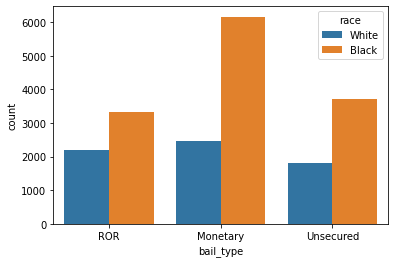

In [15]:
sns.countplot(data = df[race_filter & bail_type_filter], x='bail_type', hue='race')

In [16]:
# Create cross-tabulation of race and bail type
df_race_bailType = df[race_filter & bail_type_filter]
df_race_bailType = pd.crosstab(index=df_race_bailType['race'], columns=df_race_bailType['bail_type'])
print(df_race_bailType)#.describe()

bail_type  Monetary   ROR  Unsecured
race                                
Black          6159  3332       3724
White          2477  2212       1817


bail_type  Monetary   ROR  Unsecured
race                                
Black         46.6% 25.2%      28.2%
White         38.1% 34.0%      27.9%


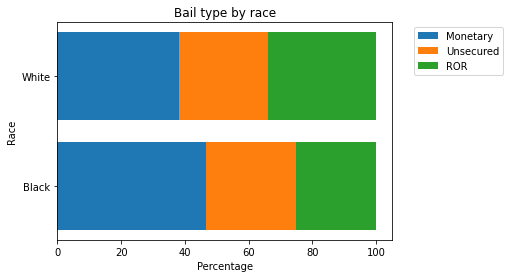

In [17]:
# Find percentage of cases for each race for which each bail type was assigned
race_sum = df_race_bailType.sum(axis=1)
df_race_bailType_percent = df_race_bailType.apply(lambda x: 100*x/race_sum)
with pd.option_context('display.float_format', '{:,.1f}%'.format):
    print(df_race_bailType_percent)

# Plot the above
x_monetary = df_race_bailType_percent["Monetary"]
x_ror = df_race_bailType_percent["ROR"]
x_unsecured = df_race_bailType_percent["Unsecured"]
ind = range(len(df_race_bailType_percent))
plt.barh(ind, x_monetary, label="Monetary")
plt.barh(ind, x_unsecured, left=x_monetary, label="Unsecured")
plt.barh(ind, x_ror, left=x_monetary+x_unsecured, label="ROR")
plt.title('Bail type by race')
plt.xlabel('Percentage')
plt.ylabel('Race')
plt.yticks(ind, ["Black", "White"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [18]:
# Chi-square test: is there a statistically significant relationship between bail type and race?
chi2, p, dof, ex = chi2_contingency(df_race_bailType)
print('p-value = {1:.2e} (chi-square = {0:.2f}, {2} dof)'.format(chi2, p, dof))

p-value = 1.75e-42 (chi-square = 192.30, 2 dof)


- Compared to White defendants, a smaller percentage of Black defendants are given ROR, and a larger percentage are given monetary bail.
- The small p-value indicates that **race and bail type are related**. Need to narrow this down:
    - Are Black defendants less likely to be given ROR?
    - Are Black defendants more likely to have monetary bail set? 
    - If true, do the above hold even when accounting for offense types?

### Race and bail amount

In [19]:
df_race_monetary = df[race_filter & (df['bail_type'] == "Monetary")]
df_race_monetary = df_race_monetary[df_race_monetary['bail_set_bin'] != 'None'] #There are a couple spurious zeros

In [20]:
# Create cross-tabulation of race and amount, by bins
ct_race_monetary = pd.crosstab(index=df_race_monetary['bail_set_bin'], columns=df_race_monetary['race'])

# Find percentage of cases for each race for which each bail type was assigned
race_sum = ct_race_monetary.sum(axis=0)
ct_race_monetary_percent = ct_race_monetary.apply(lambda x: 100*x/race_sum, axis=1)
with pd.option_context('display.float_format', '{:,.1f}%'.format):
    print(ct_race_monetary_percent)
print("Most common bin for Black defendants: {0}".format(ct_race_monetary_percent["Black"].idxmax()))
print("Most common bin for White defendants: {0}".format(ct_race_monetary_percent["White"].idxmax()))

race          Black  White
bail_set_bin              
100k to 500k  25.1%  19.0%
10k to 25k    20.6%  26.4%
1k to 5k       3.0%   4.0%
25k to 50k    16.4%  17.2%
50k to 100k   17.7%  17.6%
5k to 10k      9.2%  10.4%
<1k            3.0%   1.4%
>=500k         5.0%   4.0%
Most common bin for Black defendants: 100k to 500k
Most common bin for White defendants: 10k to 25k


<AxesSubplot:xlabel='bail_set_bin', ylabel='percentage'>

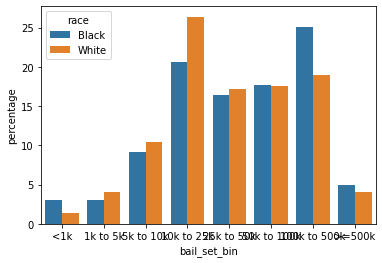

In [21]:
# Plot above as grouped bar chart
ct_stacked = ct_race_monetary_percent.reindex(bail_bin_labels[1:]).stack().reset_index().rename(columns={0:'percentage'})
sns.barplot(x=ct_stacked.bail_set_bin, y=ct_stacked.percentage, hue=ct_stacked.race, order=bail_bin_labels[1:])

In [22]:
# Chi-square test: is there a statistically significant relationship between bail type and race?
chi2, p, dof, ex = chi2_contingency(ct_race_monetary)
print('p-value = {1:.2e} (chi-square = {0:.2f}, {2} dof)'.format(chi2, p, dof))

p-value = 1.54e-15 (chi-square = 84.66, 7 dof)


- The small p-value indicates that **race and bail amount are related**. Need to narrow this down:
    - Are Black defendants likelier to recieve higher set bail amounts?
    - If true, does the above hold even when accounting for offense types?

### Accounting for offense type
TODO (Lucia):
- group by offense types in a more coarse-grained way (e.g., by article as in https://www.legis.state.pa.us/WU01/LI/LI/CT/HTM/18/18.HTM)
    - this is something we might want to do at the parsing level in the future. For now, maybe something like this? Looks like it would get very slow very quickly though https://stackoverflow.com/questions/17340922/how-to-search-if-dictionary-value-contains-certain-string-with-python
- for offense types with enough samples:
    - compare mean/median bail set for Black and White defendants: e.g., is bail set X% higher for a given offense type?
    - test of significance for such an effect, if present, across offense types

Note that this might also depend on number of offenses - how to account for that?

### Race and bail paid
- Are defendants of a given race more likely to (be able to) pay bail?

<AxesSubplot:xlabel='bail_outstanding_bin', ylabel='count'>

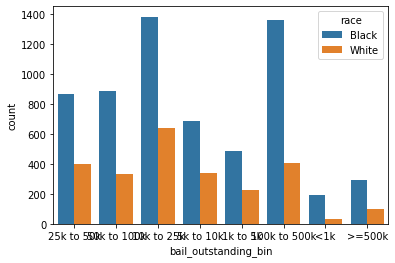

In [23]:
sns.countplot(data = df_race_monetary, x = 'bail_outstanding_bin', hue = 'race')

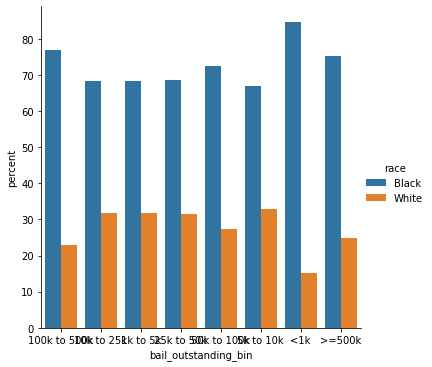

In [24]:
x,y = 'bail_outstanding_bin', 'race'

(df_race_monetary
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

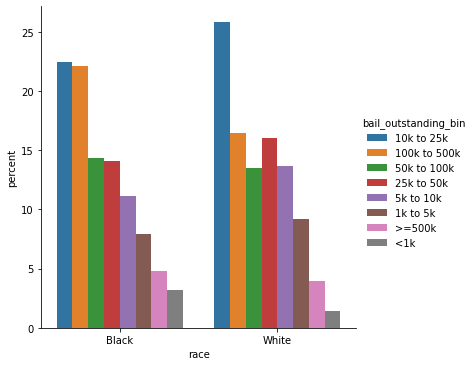

In [26]:
x,y = 'race', 'bail_outstanding_bin'

(df_race_monetary
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

# TODO: lower the amount of bail outstanding bins (i.e. widen the bins) to make the graph easier to read

Chi square test (significance level of 0.1)

In [28]:
contingency_table = pd.crosstab(index = df_race_monetary['race'], columns = df_race_monetary['bail_outstanding_bin'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

In [29]:
print('The resulting p-value is ', p)

The resulting p-value is  4.186024910118743e-14


Based on the low p-value, race and the ability to pay off bail are related.
* Are black defendants less likely to pay bail?
* If so, does this hold true across other variables (such as offense type)?

## Are sex and bail type related?

### Sex and bail type

In [27]:
df['sex'].value_counts()

Male                  17128
Female                 3294
Unreported/Unknown        1
Name: sex, dtype: int64

In [28]:
# Set sex filter to remove values without enough representation in the data
sex_filter = (df['sex'] != 'Unreported/Unknown')
df_sex = df[sex_filter]

<AxesSubplot:xlabel='bail_type', ylabel='count'>

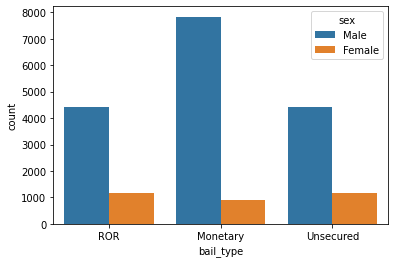

In [29]:
sns.countplot(data = df[sex_filter & bail_type_filter], x='bail_type', hue='sex')

In [30]:
# Create cross-tabulation of race and bail type
df_sex_bailType = pd.crosstab(index=df_sex['sex'], columns=df_sex['bail_type'])
df_sex_bailType = df_sex_bailType[["Monetary", "ROR", "Unsecured"]]
print(df_sex_bailType)

bail_type  Monetary   ROR  Unsecured
sex                                 
Female          908  1187       1160
Male           7834  4438       4439


bail_type   Monetary        ROR  Unsecured
sex                                       
Female     27.895545  36.466974  35.637481
Male       46.879301  26.557357  26.563342


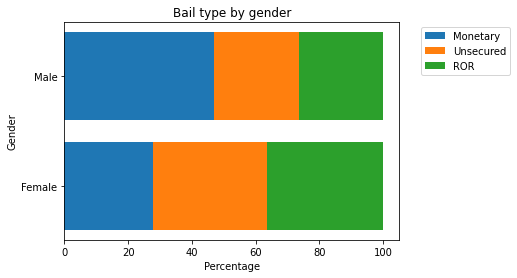

In [31]:
# Find percentage of cases for each sex for which each bail type was assigned
sex_sum = df_sex_bailType.sum(axis=1)
df_sex_bailType_percent = df_sex_bailType.apply(lambda x: 100*x/sex_sum)
print(df_sex_bailType_percent)

# Plot the above
x_monetary = df_sex_bailType_percent["Monetary"]
x_ror = df_sex_bailType_percent["ROR"]
x_unsecured = df_sex_bailType_percent["Unsecured"]
ind = range(len(df_sex_bailType_percent))
plt.barh(ind, x_monetary, label="Monetary")
plt.barh(ind, x_unsecured, left=x_monetary, label="Unsecured")
plt.barh(ind, x_ror, left=x_monetary+x_unsecured, label="ROR")
plt.title('Bail type by gender')
plt.xlabel('Percentage')
plt.ylabel('Gender')
plt.yticks(ind, ["Female", "Male"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [32]:
# Chi-square test: is there a statistically significant relationship between bail type and race?
chi2, p, dof, ex = chi2_contingency(df_sex_bailType)
print('p-value = {1:.2e} (chi-square = {0:.2f}, {2} dof)'.format(chi2, p, dof))

p-value = 2.07e-87 (chi-square = 399.19, 2 dof)


- Compared to male defendants, a larger percentage of female defendants are given either ROR or unsecured bail, and a smaller percentage are given monetary bail.
- The small p-value indicates that **sex and bail type are not independent**.

### Sex and bail amount

## Are age and bail related?

### Age and bail type

In [33]:
df['age_group'].value_counts()

26 to 33    6033
18 to 25    5821
34 to 41    4000
42 to 49    2164
50 to 57    1473
58 to 64     630
senior       222
minor         83
Name: age_group, dtype: int64

<AxesSubplot:xlabel='bail_type', ylabel='count'>

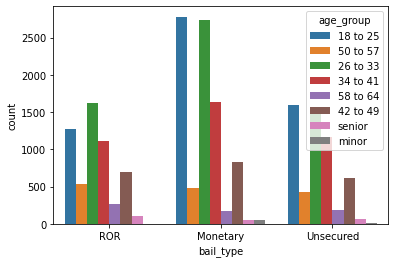

In [34]:
sns.countplot(data = df[bail_type_filter], x='bail_type', hue='age_group')

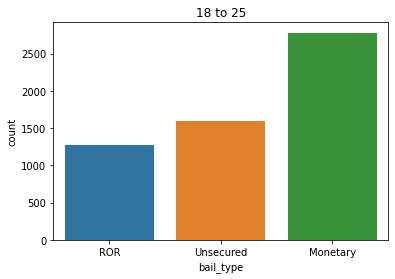

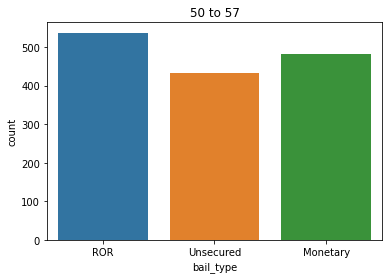

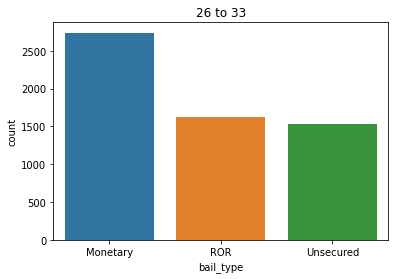

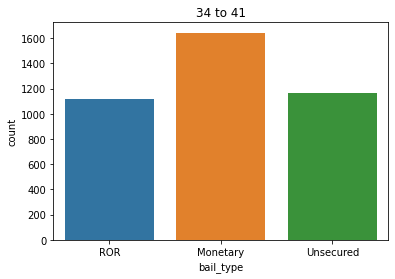

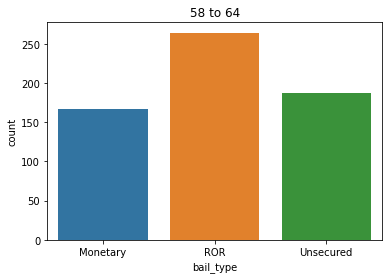

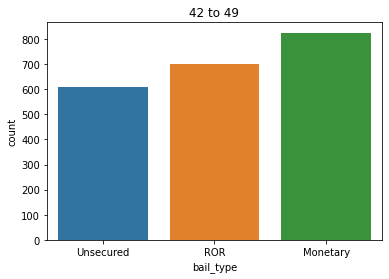

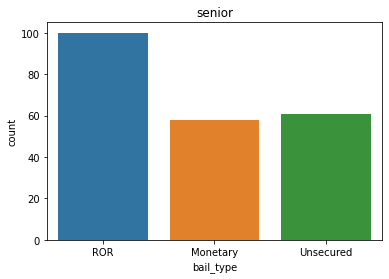

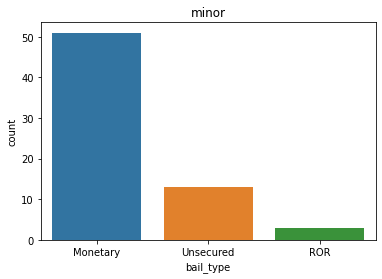

In [35]:
for i, age_group in enumerate(df['age_group'].unique()):
    plt.figure(i)
    plt.title(age_group)
    sns.countplot(data = df[bail_type_filter & (df['age_group'] == age_group)], x = 'bail_type')

### 4.? Predictive Modeling

In [36]:
#sns.pairplot(df)

# 5. How much did Philadelphians pay in bail?

Much of this analysis overlaps with section 1 - see that section for the full tally. The goal of having this section separate is to generate a compelling visualization, per Malik/the Philly Bail Fund's request, of the total amount paid by Philadelphians. 

Ideally, this would look something like the national debt clock (https://www.usdebtclock.org/), but since real-time tracking of bail paid is very difficult, we'll probably have to settle for something more like the following:
https://inorganik.github.io/countUp.js/

### 5.1 Summary Stats

**Summary statistics of bail amount**

In [38]:
monetary_bail = df[df['bail_type']=='Monetary']
monetary_bail['bail_amount'].describe()

count    8.744000e+03
mean     1.005607e+05
std      2.295750e+05
min      0.000000e+00
25%      1.000000e+04
50%      3.000000e+04
75%      1.000000e+05
max      5.000000e+06
Name: bail_amount, dtype: float64

In [39]:
monetary_bail['bail_amount'].value_counts(bins=10)

(-5000.001, 500000.0]     8542
(500000.0, 1000000.0]      156
(1500000.0, 2000000.0]      34
(2500000.0, 3000000.0]       7
(4500000.0, 5000000.0]       3
(2000000.0, 2500000.0]       2
(4000000.0, 4500000.0]       0
(3500000.0, 4000000.0]       0
(3000000.0, 3500000.0]       0
(1000000.0, 1500000.0]       0
Name: bail_amount, dtype: int64

In [40]:
bail_set_values = monetary_bail['bail_amount'].value_counts()
print("{0} unique (nonzero) bail values were set, with ${1:,.0f} being the most common ({2} times)".format(len(bail_set_values), bail_set_values.idxmax(), max(bail_set_values)))

96 unique (nonzero) bail values were set, with $25,000 being the most common (1082 times)


**Summary statistics of bail paid**

In [41]:
monetary_bail['bail_paid'].describe()

count     8744.000000
mean      2245.086345
std       4917.802319
min          0.000000
25%          0.000000
50%        500.000000
75%       2500.000000
max      75000.000000
Name: bail_paid, dtype: float64

In [42]:
monetary_bail['bail_paid'].value_counts(bins=10)

(-75.001, 7500.0]     8138
(7500.0, 15000.0]      433
(22500.0, 30000.0]      76
(15000.0, 22500.0]      66
(45000.0, 52500.0]      18
(30000.0, 37500.0]       8
(67500.0, 75000.0]       3
(37500.0, 45000.0]       2
(60000.0, 67500.0]       0
(52500.0, 60000.0]       0
Name: bail_paid, dtype: int64

In [43]:
monetary_bail['bail_paid'].value_counts()

0.0        4074
2500.0      753
1000.0      652
5000.0      583
500.0       446
           ... 
27500.0       1
25.0          1
32500.0       1
5030.0        1
1550.0        1
Name: bail_paid, Length: 66, dtype: int64

### 5.2 Bail Amount vs. Bail Paid Across Offense Types

In [44]:
# requires nmf topic modeling results